See:

* [Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)
* [Demo of Pandas and Scikit-learn](https://www.kaggle.com/evanli1999/titanic-a-demo-of-pandas-and-scikit-learn)


# 0. Import libraries

In [2]:
# Python 3

# Load packages
import sys               # access to system parameters
import pandas     as pd  # Handle tables
import numpy      as np  # Handle matrices
import scipy      as sp  # Scientific computing
import sklearn    as skl # Machine learning
import matplotlib as mpl # Visualization
import seaborn    as sns # Visualization
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook

print("Python version:       ", sys.version)
print("Pandas version:       ", pd.__version__)
print("NumPy version:        ", np.__version__)
print("SciPy version:        ", sp.__version__) 
print("IPython version:      ", IPython.__version__) 
print("Scikit-learn version: ", skl.__version__)
print("Matplotlib version:   ", mpl.__version__)
print("Seaborn version:      ", sns.__version__)

# Misc libraries
import random
import time
import re

# Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
#from xgboost import XGBClassifier

# Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

# Visualization
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pandas.tools.plotting import scatter_matrix

# Configure visualisations
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 # 8,6

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

Python version:        3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 18:10:19) 
[GCC 7.2.0]
Pandas version:        0.22.0
NumPy version:         1.14.2
SciPy version:         1.0.1
IPython version:       6.2.1
Scikit-learn version:  0.19.1
Matplotlib version:    2.1.2
Seaborn version:       0.8.1


# 1. Load data

```
Field       Type                    Description
==============================================================================
PassengerId (excluded)              Random unique identifier
Ticket      (excluded)              Random unique identifier (PC 17599)
Age         continuous quantitative Age in years (decimal)
Fare        continuous quantitative Passenger fare (71.2833)
SibSp       discrete quantitative   # of siblings / spouses aboard the Titanic
Parch       discrete quantitative   # of parents / children aboard the Titanic
Pclass      ordinal                 ticket class (1=1st, 2=2nd, 3=3rd)
Name        nominal                 name
Sex         nominal                 [male, female]
Embarked    nominal                 [C=Cherbourg, Q=Queenstown, S=Southampton]
Cabin       nominal (excluded*)     Cabin number (C85)
Survived    binary nominal          survival (0=no, 1=yes)
```
The Cabin variable is a nominal datatype that can be used in feature engineering
for approximate position on ship when the incident occurred and SES from deck levels.
However, since there are many null values, it does not add value and thus is excluded from analysis.

In [3]:
data       = pd.read_csv("data/train.csv")
data_val   = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/gender_submission.csv")

# To play with our data we'll create a copy
# Remember python assignment or equal passes by reference vs values, so we use the copy function
data1 = data.copy(deep = True)

# However passing by reference is convenient, because we can clean both datasets at once
data_cleaner = [data1, data_val]

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# 2. Clean data

### The 4 C's of Data Cleaning: Correcting, Completing, Creating, and Converting

1. correcting aberrant values and outliers
2. completing missing information
3. creating new features for analysis
4. converting fields to the correct format for calculations and presentation.

In [5]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


## 2.2 Complete
Complete or delete missing values in train and test/validation dataset

In [6]:
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
data1.drop(drop_column, axis=1, inplace = True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


## CREATE
Feature Engineering for train and test/validation dataset

In [7]:
for dataset in data_cleaner:    
    #Discrete variables
    dataset['FamilySize'] = dataset ['SibSp'] + dataset['Parch'] + 1

    dataset['IsAlone'] = 1 #initialize to yes/1 is alone
    dataset['IsAlone'].loc[dataset['FamilySize'] > 1] = 0 # now update to no/0 if family size is greater than 1

    #quick and dirty code split title from name: http://www.pythonforbeginners.com/dictionary/python-split
    dataset['Title'] = dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]


    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


    
#cleanup rare title names
#print(data1['Title'].value_counts())
stat_min = 10 #while small is arbitrary, we'll use the common minimum in statistics: http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (data1['Title'].value_counts() < stat_min) #this will create a true false series with title name as index

#apply and lambda functions are quick and dirty code to find and replace with fewer lines of code: https://community.modeanalytics.com/python/tutorial/pandas-groupby-and-python-lambda-functions/
data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(data1['Title'].value_counts())
print("-"*10)


#preview data again
#data1.info()
#data_val.info()
data1.sample(5)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
347,1,3,"Davison, Mrs. Thomas Henry (Mary E Finck)",female,28.0,1,0,16.1000,S,2,0,Mrs,"(14.454, 31.0]","(16.0, 32.0]"
820,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,93.5000,S,3,0,Mrs,"(31.0, 512.329]","(48.0, 64.0]"
536,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,26.5500,S,1,1,Misc,"(14.454, 31.0]","(32.0, 48.0]"
10,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,16.7000,S,3,0,Miss,"(14.454, 31.0]","(-0.08, 16.0]"
22,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,8.0292,Q,1,1,Miss,"(7.91, 14.454]","(-0.08, 16.0]"


## 2.2 Convert Formats

In [8]:
#CONVERT: convert objects to category using Label Encoder for train and test/validation dataset

#code categorical data
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code']      = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code']    = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code']   = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code']  = label.fit_transform(dataset['FareBin'])


#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] #pretty name/values for charts
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Misc', 'Title_Miss', 'Title_Mr', 'Title_Mrs'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0


## Split Training and Testing Data

In [19]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x,       test1_x,       train1_y,       test1_y       = model_selection.train_test_split(data1[data1_x_calc],        data1[Target], random_state = 0)
train1_x_bin,   test1_x_bin,   train1_y_bin,   test1_y_bin   = model_selection.train_test_split(data1[data1_x_bin],         data1[Target], random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,3,1,1,0
68,0,3,2,2,7,1,1
253,1,3,2,3,2,1,2
320,1,3,2,3,1,1,0
706,0,2,2,4,1,2,1


# 4: Perform Exploratory Analysis with Statistics
Now that our data is cleaned, we will explore our data with descriptive and graphical statistics to describe and summarize our variables. In this stage, you will find yourself classifying features and determining their correlation with the target variable and each other.


In [20]:
#Discrete Variable Correlation by Survival using
#group by aka pivot table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for x in data1_x:
    if data1[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(data1[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')
        

#using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(data1['Title'],data1[Target[0]]))

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: Title
    Title  Survived
0  Master  0.575000
1    Misc  0.444444
2    Miss  0.697802
3      Mr  0.156673
4     Mrs  0.792000
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1 

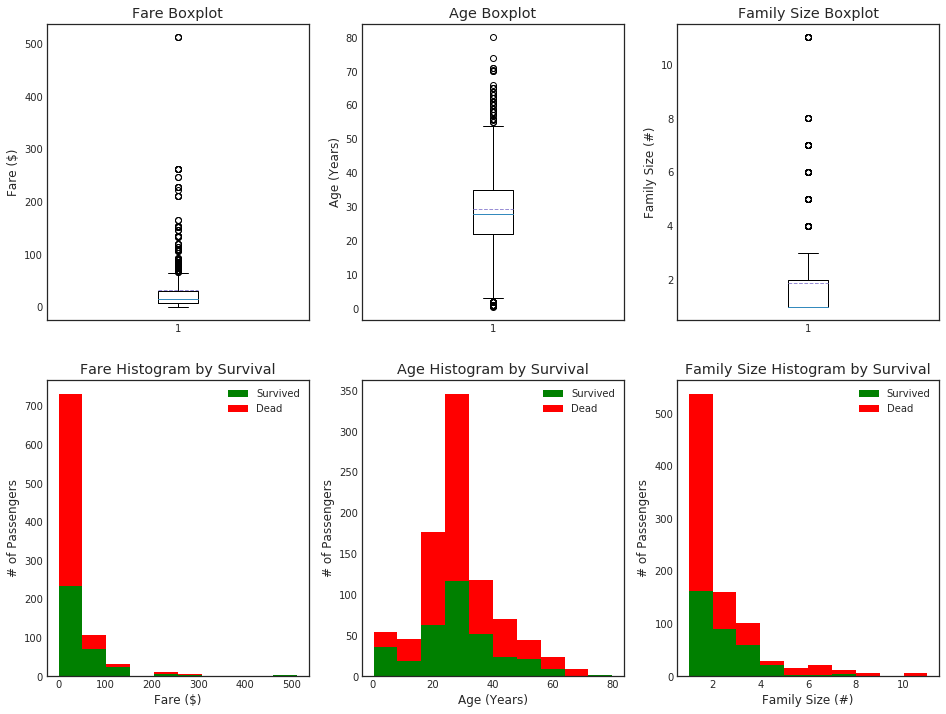

In [21]:
#IMPORTANT: Intentionally plotted different ways for learning purposes only. 

#optional plotting w/pandas: https://pandas.pydata.org/pandas-docs/stable/visualization.html

#we will use matplotlib.pyplot: https://matplotlib.org/api/pyplot_api.html

#to organize our graphics will use figure: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.figure.html#matplotlib.pyplot.figure
#subplot: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html#matplotlib.pyplot.subplot
#and subplotS: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplots.html?highlight=matplotlib%20pyplot%20subplots#matplotlib.pyplot.subplots

#graph distribution of quantitative data
plt.figure(figsize=[16,12])

plt.subplot(231)
plt.boxplot(x=data1['Fare'], showmeans = True, meanline = True)
plt.title('Fare Boxplot')
plt.ylabel('Fare ($)')

plt.subplot(232)
plt.boxplot(data1['Age'], showmeans = True, meanline = True)
plt.title('Age Boxplot')
plt.ylabel('Age (Years)')

plt.subplot(233)
plt.boxplot(data1['FamilySize'], showmeans = True, meanline = True)
plt.title('Family Size Boxplot')
plt.ylabel('Family Size (#)')

plt.subplot(234)
plt.hist(x = [data1[data1['Survived']==1]['Fare'], data1[data1['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Fare Histogram by Survival')
plt.xlabel('Fare ($)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(235)
plt.hist(x = [data1[data1['Survived']==1]['Age'], data1[data1['Survived']==0]['Age']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Age Histogram by Survival')
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
plt.legend()

plt.subplot(236)
plt.hist(x = [data1[data1['Survived']==1]['FamilySize'], data1[data1['Survived']==0]['FamilySize']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'])
plt.title('Family Size Histogram by Survival')
plt.xlabel('Family Size (#)')
plt.ylabel('# of Passengers')
plt.legend()

# Models

In [22]:


#Machine Learning Algorithm (MLA) Selection and Initialization
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    #XGBClassifier()    
]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target], cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1

    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.891386,0.827239,0.0541611,0.00813584
14,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",0.837266,0.826119,0.0453876,0.0286355
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.891573,0.824627,0.0498103,0.00884783
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.895131,0.823881,0.0624864,0.00770981
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.866667,0.822761,0.0498731,0.0373248
15,NuSVC,"{'cache_size': 200, 'class_weight': None, 'coe...",0.835768,0.822761,0.0493681,0.0348626
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.821269,0.056516,0.000980115
18,ExtraTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.895131,0.816418,0.0570347,0.000845695
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.850375,0.813806,0.0690863,0.000971055
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.820412,0.81194,0.0498606,0.0390241


Text(0,0.5,'Algorithm')

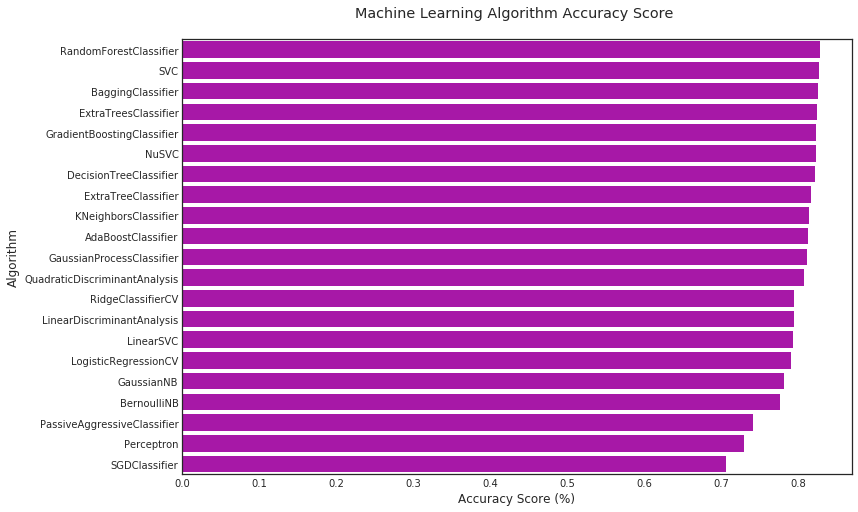

In [25]:
#barplot using https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### Logistic regression

In [34]:
logistic_model = LogisticRegression().fit(x_train, y_train.values.ravel())
logistic_prediction = logistic_model.predict(x_test)

accuracy_score(logistic_prediction, y_test)

0.8805970149253731

### Decision tree

In [35]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)
dt_prediction = dt.predict(x_test)

accuracy_score(dt_prediction, y_test)

0.8582089552238806

### Random forest

In [36]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf_prediction = rf.predict(x_test)

accuracy_score(rf_prediction, y_test)

0.8283582089552238

### Neural net (150 hidden units)

In [37]:
clf = MLPClassifier(activation = 'relu', solver='lbfgs', hidden_layer_sizes=(150), random_state=10)
clf.fit(x_train, y_train)
neural_prediction = clf.predict(x_test)

accuracy_score(neural_prediction, y_test)

0.8656716417910447